## Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


## Load the dataset

In [2]:
data = pd.read_csv("bitcoin_ticker.csv")

In [3]:
data.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
0,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_eur,1996.72,2029.99,-1.638924,2005.50,2005.56,1950.00,2063.73,2314.500750,2017-05-31 14:59:36,2017-05-31 14:59:36
1,2017-05-31,2017-06-01 00:00:00,bitflyer,btc_jpy,267098.00,269649.00,-0.946045,267124.00,267267.00,267124.00,267267.00,70922.880112,2017-05-31 14:59:36,2017-05-31 14:59:36
2,2017-05-31,2017-06-01 00:00:00,korbit,btc_krw,3003500.00,3140000.00,-4.347134,3003500.00,3004000.00,3002000.00,3209500.00,6109.752872,2017-05-31 14:59:36,2017-05-31 14:59:36
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36


In [4]:
data['rpt_key'].value_counts()

btc_usd       125438
btc_jpy        62719
btc_eur        62719
eth_btc        62719
etc_krw        62719
fx_btc_jpy     62719
eth_krw        62719
btc_krw        62719
ltc_usd        62719
Name: rpt_key, dtype: int64

## Subset USD

In [18]:
df = data.loc[(data['rpt_key'] == 'btc_usd')]

In [19]:
df.head()

,date_id,datetime_id,market,rpt_key,last,diff_24h,diff_per_24h,bid,ask,low,high,volume,created_at,updated_at
3,2017-05-31,2017-06-01 00:00:00,bitstamp,btc_usd,2237.40,2239.37,-0.087971,2233.09,2237.40,2154.28,2293.46,13681.282017,2017-05-31 14:59:36,2017-05-31 14:59:36
4,2017-05-31,2017-06-01 00:00:00,okcoin,btc_usd,2318.82,2228.70,4.043613,2319.40,2319.99,2129.78,2318.82,4241.641516,2017-05-31 14:59:36,2017-05-31 14:59:36
15,2017-06-01,2017-06-01 00:01:00,bitstamp,btc_usd,2248.39,2242.44,0.265336,2247.77,2248.38,2154.28,2293.46,13701.698603,2017-05-31 15:00:36,2017-05-31 15:00:36
16,2017-06-01,2017-06-01 00:01:00,okcoin,btc_usd,2320.42,2228.40,4.129420,2320.99,2321.49,2129.78,2322.00,4260.261516,2017-05-31 15:00:36,2017-05-31 15:00:36
23,2017-06-01,2017-06-01 00:02:00,bitstamp,btc_usd,2248.35,2238.58,0.436437,2248.35,2248.69,2154.28,2293.46,13742.110913,2017-05-31 15:01:36,2017-05-31 15:01:36


### Convert datetime_id to data type and filter dates greater than  2017-06-28 00:00:00

In [20]:
df = df.reset_index(drop=True)
df['datetime'] = pd.to_datetime(df['datetime_id'])
df = df.loc[df['datetime'] > pd.to_datetime('2017-06-01 00:00:00')]

In [21]:
df = df[['datetime', 'last', 'diff_24h', 'diff_per_24h', 'bid', 'ask', 'low', 'high', 'volume']]

In [22]:
df.head()

,datetime,last,diff_24h,diff_per_24h,bid,ask,low,high,volume
2,2017-06-01 00:01:00,2248.39,2242.44,0.265336,2247.77,2248.38,2154.28,2293.46,13701.698603
3,2017-06-01 00:01:00,2320.42,2228.40,4.129420,2320.99,2321.49,2129.78,2322.00,4260.261516
4,2017-06-01 00:02:00,2248.35,2238.58,0.436437,2248.35,2248.69,2154.28,2293.46,13742.110913
5,2017-06-01 00:02:00,2323.50,2229.99,4.193292,2323.50,2323.51,2129.78,2323.50,4263.031516
6,2017-06-01 00:03:00,2250.00,2245.99,0.178540,2250.10,2251.44,2154.28,2293.46,13798.457716


### we require only the last value, so we subset that and convert it to numpy array

In [23]:
df = df[['last']]

In [24]:
dataset = df.values
dataset = dataset.astype('float32')

In [25]:
print(dataset)
print(dataset.shape)

[[2248.39]
 [2320.42]
 [2248.35]
 ...
 [2394.03]
 [2320.47]
 [2394.03]]
(125436, 1)


Neural networks are sensitive to input data, especiallly when we are using activation functions like sigmoid or tanh activation functions are used. ISo we rescale our data to the range of 0-to-1, using MinMaxScaler

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [27]:
print(dataset)
print(dataset.shape)

[[0.00889039]
 [0.08530831]
 [0.00884819]
 ...
 [0.1634028 ]
 [0.08536148]
 [0.1634028 ]]
(125436, 1)


In [28]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

84042 41394


Now let us define the function called create_dataset, which take two inputs, 

1. Dataset - numpy array that we want to convert into a dataset
2. look_back - number of previous time steps to use as input variables to predict the next time period


In [29]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [30]:
look_back = 10
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [31]:
trainX[0]

array([0.00889039, 0.08530831, 0.00884819, 0.08857608, 0.01059866,
       0.13196754, 0.01460886, 0.13744211, 0.01843882, 0.14296937],
      dtype=float32)

In [33]:
trainY[0]

0.016645908

In [35]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Build our Model

In [36]:
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=256, verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 5s - loss: 0.0300
Epoch 2/200
 - 1s - loss: 0.0057
Epoch 3/200
 - 1s - loss: 0.0012
Epoch 4/200
 - 1s - loss: 1.1438e-04
Epoch 5/200
 - 1s - loss: 6.7518e-05
Epoch 6/200
 - 1s - loss: 5.4526e-05
Epoch 7/200
 - 1s - loss: 4.6514e-05
Epoch 8/200
 - 1s - loss: 4.2009e-05
Epoch 9/200
 - 1s - loss: 3.9671e-05
Epoch 10/200
 - 1s - loss: 3.6711e-05
Epoch 11/200
 - 1s - loss: 3.4276e-05
Epoch 12/200
 - 1s - loss: 3.2588e-05
Epoch 13/200
 - 1s - loss: 3.1636e-05
Epoch 14/200
 - 1s - loss: 3.0835e-05
Epoch 15/200
 - 1s - loss: 3.0161e-05
Epoch 16/200
 - 1s - loss: 2.9435e-05
Epoch 17/200
 - 1s - loss: 2.8935e-05
Epoch 18/200
 - 1s - loss: 2.8151e-05
Epoch 19/200
 - 1s - loss: 2.7654e-05
Epoch 20/200
 - 1s - loss: 2.7136e-05
Epoch 21/200
 - 1s - loss: 2.6378e-05
Epoch 22/200
 - 1s - loss: 2.5732e-05
Epoch 23/200
 - 1s - loss: 2.5207e-05
Epoch 24/200
 - 1s - loss: 2.4552e-05
Epoch 25/200
 - 1s - loss: 2.3812e-05
Epoch 26/200
 - 1s - lo

In [37]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

We have to invert the predictions before calculating error to so that reports will be in same units as our original data

In [38]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [39]:

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 3.33 RMSE
Test Score: 4.74 RMSE


In [40]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict
 

In [41]:
 # shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict
 


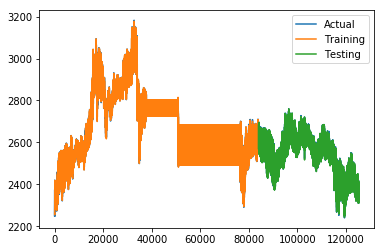

In [52]:
plt.plot(df['last'], label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot, columns=["close"], index=df.index).close, label='Training')
plt.plot(pd.DataFrame(testPredictPlot, columns=["close"], index=df.index).close, label='Testing')
plt.legend(loc='best')
plt.show()#[500,500])

In [1]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
model = Sequential()

In [7]:
model.add(LSTM(5,activation="relu",return_sequences = True,input_shape=(None,1)))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.
